In [1]:
import numpy as np
from graph_cert.certify import *
from graph_cert.utils import *
from graph_cert.models import PiPPNP
from graph_cert.training import *
from functools import partial

import seaborn as sns
import tqdm
import matplotlib.pyplot as plt

### Load and preprocess the data

In [2]:
file_name = 'data/citeseer.npz'
graph = load_dataset(file_name=file_name)

adj_matrix, attr_matrix, labels = standardize(adj_matrix=graph['adj_matrix'],
                                              attr_matrix=graph['attr_matrix'],
                                              labels=graph['labels'])

idx_train, idx_val, idx_test = split(labels, n_per_class=20, seed=0)

### Setup the training function with default hyper-params


In [3]:
device = 'cuda'
alpha = 0.85
n, d = attr_matrix.shape
nc = labels.max()+1

attr = torch.FloatTensor(attr_matrix.toarray()).to(device)
ppr = torch.FloatTensor(propagation_matrix(adj_matrix, alpha=alpha)).to(device)
labels = torch.LongTensor(labels).to(device)

In [4]:
train_func = partial(train, attr=attr, ppr=ppr, labels=labels,
                     idx_train=idx_train, idx_val=idx_val,
                     lr=1e-2, weight_decay= 1e-4,
                     patience=50, max_epochs=3_000, display_step=5,
                    )

### Train $\pi$-PPNP using standard cross-entropy loss

In [5]:
ppnp_ce = PiPPNP(n_features=d, n_classes=nc, n_hidden=[64]).to(device)
_ = train_func(model=ppnp_ce, adver_config=None)

Epoch    0: loss_train: 1.79571, loss_val: 1.79499  acc_train: 0.15000, acc_val: 0.17500 p_robust -1.00000
Epoch    5: loss_train: 0.56064, loss_val: 1.02474  acc_train: 0.86667, acc_val: 0.65833 p_robust -1.00000
Epoch   10: loss_train: 0.12894, loss_val: 1.08670  acc_train: 0.96667, acc_val: 0.66667 p_robust -1.00000
Epoch   15: loss_train: 0.03541, loss_val: 1.50060  acc_train: 1.00000, acc_val: 0.65833 p_robust -1.00000
Epoch   20: loss_train: 0.01410, loss_val: 1.86582  acc_train: 1.00000, acc_val: 0.66667 p_robust -1.00000
Epoch   25: loss_train: 0.00669, loss_val: 2.02315  acc_train: 1.00000, acc_val: 0.65000 p_robust -1.00000
Epoch   30: loss_train: 0.00396, loss_val: 2.06998  acc_train: 1.00000, acc_val: 0.63333 p_robust -1.00000
Epoch   35: loss_train: 0.00285, loss_val: 2.04542  acc_train: 1.00000, acc_val: 0.64167 p_robust -1.00000
Epoch   40: loss_train: 0.00233, loss_val: 1.96238  acc_train: 1.00000, acc_val: 0.65000 p_robust -1.00000
Epoch   45: loss_train: 0.00216, loss

### Configure the paramters for adversarial training

In [6]:
# set the local budget proportional to the degree
deg = adj_matrix.sum(1).A1.astype(np.int32)
local_strength = 9
local_budget = np.maximum(deg - 11 + local_strength, 0)

fragile = get_fragile(adj=adj_matrix, threat_model='rem')

adver_config = {
    'alpha': alpha,
    'adj_matrix': adj_matrix,
    'fragile': fragile,
    'local_budget': local_budget,
    'margin': 1
}

### Train $\pi$-PPNP using robust cross-entropy loss

In [7]:
adver_config['loss_type'] = 'rce'
ppnp_rce = PiPPNP(n_features=d, n_classes=nc, n_hidden=[64]).to(device)
_ = train_func(model=ppnp_rce, adver_config=adver_config)

Epoch    0: loss_train: 1.79752, loss_val: 1.79893  acc_train: 0.16667, acc_val: 0.16667 p_robust 0.16667
Epoch    5: loss_train: 0.73579, loss_val: 1.23677  acc_train: 0.88333, acc_val: 0.65833 p_robust 0.72500
Epoch   10: loss_train: 0.24057, loss_val: 1.43396  acc_train: 0.95833, acc_val: 0.65833 p_robust 0.75000
Epoch   15: loss_train: 0.10475, loss_val: 1.98628  acc_train: 0.99167, acc_val: 0.62500 p_robust 0.77500
Epoch   20: loss_train: 0.05517, loss_val: 2.47296  acc_train: 1.00000, acc_val: 0.63333 p_robust 0.75833
Epoch   25: loss_train: 0.03283, loss_val: 2.71785  acc_train: 1.00000, acc_val: 0.64167 p_robust 0.77083
Epoch   30: loss_train: 0.02119, loss_val: 2.84580  acc_train: 1.00000, acc_val: 0.62500 p_robust 0.76250
Epoch   35: loss_train: 0.01520, loss_val: 2.87234  acc_train: 1.00000, acc_val: 0.61667 p_robust 0.75833
Epoch   40: loss_train: 0.01200, loss_val: 2.81991  acc_train: 1.00000, acc_val: 0.60833 p_robust 0.76250
Epoch   45: loss_train: 0.01005, loss_val: 2.7

### Train $\pi$-PPNP using robust hinge loss

In [8]:
adver_config['loss_type'] = 'cem'
ppnp_cem = PiPPNP(n_features=d, n_classes=nc, n_hidden=[64]).to(device)
_ = train_func(model=ppnp_cem, adver_config=adver_config)

Epoch    0: loss_train: 6.82987, loss_val: 6.82964  acc_train: 0.16667, acc_val: 0.16667 p_robust 0.16667
Epoch    5: loss_train: 1.19163, loss_val: 2.91158  acc_train: 0.89167, acc_val: 0.66667 p_robust 0.75000
Epoch   10: loss_train: 0.40587, loss_val: 3.34032  acc_train: 0.95000, acc_val: 0.64167 p_robust 0.74583
Epoch   15: loss_train: 0.18605, loss_val: 4.13616  acc_train: 1.00000, acc_val: 0.62500 p_robust 0.75417
Epoch   20: loss_train: 0.10668, loss_val: 4.77957  acc_train: 1.00000, acc_val: 0.62500 p_robust 0.75833
Epoch   25: loss_train: 0.06860, loss_val: 5.16008  acc_train: 1.00000, acc_val: 0.62500 p_robust 0.75000
Epoch   30: loss_train: 0.04587, loss_val: 5.57329  acc_train: 1.00000, acc_val: 0.61667 p_robust 0.76667
Epoch   35: loss_train: 0.03348, loss_val: 5.65594  acc_train: 1.00000, acc_val: 0.60833 p_robust 0.74583
Epoch   40: loss_train: 0.01996, loss_val: 5.70675  acc_train: 1.00000, acc_val: 0.60833 p_robust 0.75417
Epoch   45: loss_train: 0.01500, loss_val: 5.7

### Compute the ratios of certified test nodes

In [9]:
local_strengths = [1, 3, 5, 7, 9]
ratios_certifed = np.zeros((3, len(local_strengths)))

for it, model in enumerate(tqdm.tqdm_notebook([ppnp_ce, ppnp_cem, ppnp_rce])):
    
    logits, weighted_logits = model(attr, ppr)
    acc_test = accuracy(labels, weighted_logits, idx_test)
    print(f'Accuracy: {acc_test:.5f}')
    
    logits = logits.detach().cpu().numpy()
    predicted = weighted_logits.argmax(1).cpu().numpy()

    for jt, local_strength in enumerate(tqdm.tqdm_notebook(local_strengths, leave=False)):
        # set the local budget proportional to the node degree
        local_budget = np.maximum(deg - 11 + local_strength, 0)

        # precomputed the K x K perturbed graphs
        k_squared_pageranks = k_squared_parallel(
        adj=adj_matrix, alpha=alpha, fragile=fragile, local_budget=local_budget, logits=logits, nodes=idx_test)

        # compute the exact worst-case margins for all test nodes
        worst_margins = worst_margins_given_k_squared(
            k_squared_pageranks=k_squared_pageranks, labels=predicted[idx_test], logits=logits)

        ratios_certifed[it, jt] = (worst_margins>0).mean()

Accuracy: 0.69198


Accuracy: 0.68717


Accuracy: 0.69091


### Compare different losses

Note: Since GNNs are known to be senstive to choice of train/valid/test split a proper comparison should adverage of several different random splits.

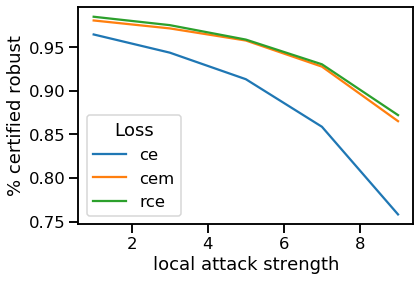

In [10]:
sns.set_context('talk')
plt.plot(local_strengths, ratios_certifed[0], label='ce')
plt.plot(local_strengths, ratios_certifed[1], label='cem')
plt.plot(local_strengths, ratios_certifed[2], label='rce')
plt.xlabel('local attack strength')
plt.ylabel('% certified robust')
plt.legend(title='Loss')
plt.show()